# Purity/Efficiency Plot of the SPANet Resolved Output

In [1]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
# read test target file
test_file = "//Users/billyli/UCSD/hhh/reports/bv2/hhh_test.h5"
test_h5 = h5.File(test_file)

# read baseline prediction
baseline_file = "//Users/billyli/UCSD/hhh/reports/bv2/pred_baseline.h5"
b_h5 = h5.File(baseline_file)

# read spanet prediction
spanet_file = "//Users/billyli/UCSD/hhh/reports/bv2/dp_on/pred_v53.h5"
s_h5 = h5.File(spanet_file)

In [3]:
test_h5['TARGETS'].keys()

<KeysViewHDF5 ['bh1', 'bh2', 'bh3', 'h1', 'h2', 'h3']>

In [4]:
def sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=0.0, ap_cut=0):
    # parse predicted bb assignment by DP
    dp_filter = dps > dp_cut
    ap_filter = aps > ap_cut
    b1_ak4_filter = b1_ps<10
    b2_ak4_filter = b2_ps<10
    filter = dp_filter & ap_filter & b1_ak4_filter & b2_ak4_filter
    
    b1_ps_passed = b1_ps.mask[filter]
    b1_ps_passed = ak.drop_none(b1_ps_passed)
    
    b2_ps_passed = b2_ps.mask[filter]
    b2_ps_passed = ak.drop_none(b2_ps_passed)
    
    return b1_ps_passed, b2_ps_passed

In [5]:
def sel_target_h_by_mask(b1_ts, b2_ts, h_pts, h_masks):
    b1_ts_selected = b1_ts.mask[h_masks]
    b1_ts_selected = ak.drop_none(b1_ts_selected)
    
    b2_ts_selected = b2_ts.mask[h_masks]
    b2_ts_selected = ak.drop_none(b2_ts_selected)
    
    h_selected_pts = h_pts.mask[h_masks]
    h_selected_pts = ak.drop_none(h_selected_pts)
    
    return b1_ts_selected, b2_ts_selected, h_selected_pts

In [6]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct, pred_H_pt, pred_b1, pred_b2]]
@nb.njit
def gen_pred_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, jets_e, goodJetIdx_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        builder.begin_list()
        for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
            correct = 0
            predH_pt = (jets_e[b1_p]+jets_e[b2_p]).pt
            for b1_t, b2_t in zip(b1_ts_e, b2_ts_e):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)) and (b1_p in goodJetIdx_e) and (b2_p in goodJetIdx_e):
                    correct = 1
            builder.begin_list()
            builder.append(correct)
            builder.append(predH_pt)
            builder.append(b1_p)
            builder.append(b2_p)
            builder.end_list()
        
        builder.end_list()
    return builder

In [7]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt, target_b1, target_b2]]
@nb.njit
def gen_target_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, tH_pts_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        builder.begin_list()
        for b1_t, b2_t, tH_pt in zip(b1_ts_e, b2_ts_e, tH_pts_e):
            retrieved = 0
            for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)):
                    retrieved = 1
            builder.begin_list()
            builder.append(retrieved)
            builder.append(tH_pt)
            builder.append(b1_t)
            builder.append(b2_t)
            builder.end_list()
        
        builder.end_list()
    return builder

In [8]:
def parse_resolved_w_target(testfile, predfile, dp_cut=0.5, fjs_reco=None):
    # h pt
    h1_pt = np.array(testfile['TARGETS']['h1']['pt'])
    h2_pt = np.array(testfile['TARGETS']['h2']['pt'])
    h3_pt = np.array(testfile['TARGETS']['h3']['pt'])
    
    # mask
    h1_mask = np.array(testfile['TARGETS']['h1']['mask'])
    h2_mask = np.array(testfile['TARGETS']['h2']['mask'])
    h3_mask = np.array(testfile['TARGETS']['h3']['mask'])
    
    # target assignments
    b1_h1_t = np.array(testfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_t = np.array(testfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_t = np.array(testfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_t = np.array(testfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_t = np.array(testfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_t = np.array(testfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])
    
    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])
    
    # reconstruct jet 4-momentum objects
    j_pt = np.array(testfile['INPUTS']['Jets']['pt'])
    j_eta = np.array(testfile['INPUTS']['Jets']['eta'])
    j_phi = np.array(testfile['INPUTS']['Jets']['phi'])
    j_mass = np.array(testfile['INPUTS']['Jets']['mass'])
    js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D"
    )
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    aps = ak.Array(aps)
    
    b1_ps = np.concatenate((b1_h1_p.reshape(-1, 1), b1_h2_p.reshape(-1, 1), b1_h3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b1_ts = np.concatenate((b1_h1_t.reshape(-1, 1), b1_h2_t.reshape(-1, 1), b1_h3_t.reshape(-1, 1)), axis=1)
    b1_ts = ak.Array(b1_ts)
    b2_ps = np.concatenate((b2_h1_p.reshape(-1, 1), b2_h2_p.reshape(-1, 1), b2_h3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)
    b2_ts = np.concatenate((b2_h1_t.reshape(-1, 1), b2_h2_t.reshape(-1, 1), b2_h3_t.reshape(-1, 1)), axis=1)
    b2_ts = ak.Array(b2_ts)

    h_masks = np.concatenate((h1_mask.reshape(-1, 1), h2_mask.reshape(-1, 1), h3_mask.reshape(-1, 1)), axis=1)
    h_masks = ak.Array(h_masks)
    
    h_pts = np.concatenate((h1_pt.reshape(-1, 1), h2_pt.reshape(-1, 1), h3_pt.reshape(-1, 1)), axis=1)
    h_pts = ak.Array(h_pts)
    
    # select predictions and targets
    b1_ts_selected, b2_ts_selected, targetH_selected_pts = sel_target_h_by_mask(b1_ts, b2_ts, h_pts, h_masks)
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=dp_cut)
    
    # find jets that are overlapped with reco boosted Higgs
    if fjs_reco is None:
        goodJetIdx =  ak.local_index(js)
    else:
        goodJetIdx = get_unoverlapped_jet_index(fjs_reco, js)
    
    # generate look up tables
    LUT_pred = gen_pred_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, js, goodJetIdx, ak.ArrayBuilder()).snapshot()
    LUT_target = gen_target_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, targetH_selected_pts, ak.ArrayBuilder()).snapshot()
    
    
    return LUT_pred, LUT_target

In [9]:
# calculate efficiency
# if bins=None, put all data in a single bin
def calc_eff(LUT_pred, bins):
    predHs = [predH for event in LUT_pred for predH in event]
    predHs = np.array(predHs)
    
    predHs_inds = np.digitize(predHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(predHs[:,0][predHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [10]:
# calculate purity
def calc_pur(LUT_target, bins):
    targetHs = [targetH for event in LUT_target for targetH in event]
    targetHs = np.array(targetHs)
    
    targetHs_inds = np.digitize(targetHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [11]:
bins = np.arange(0, 850, 50)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]
xerr=(bins[1]-bins[0])/2*np.ones(bins.shape[0]-1)

In [12]:
dp_cut = 0.5
LUT_pred_spanet, LUT_target_spanet = parse_resolved_w_target(test_h5, s_h5, dp_cut=dp_cut, fjs_reco=None)
LUT_pred_base, LUT_target_base = parse_resolved_w_target(test_h5, b_h5, dp_cut=dp_cut, fjs_reco=None)

In [13]:
eff_s, efferr_s = calc_eff(LUT_pred_spanet, bins)
pur_s, purerr_s = calc_pur(LUT_target_spanet, bins)

eff_b, efferr_b = calc_eff(LUT_pred_base, bins)
pur_b, purerr_b = calc_pur(LUT_target_base, bins)

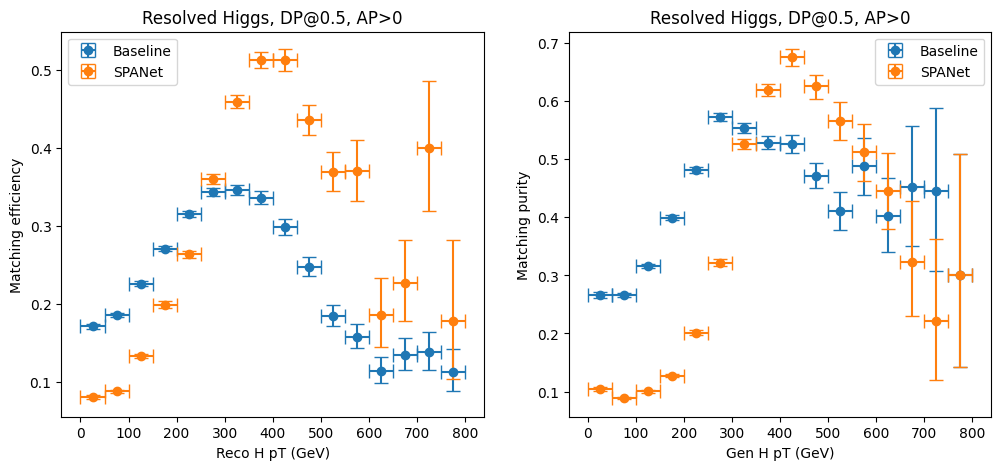

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].errorbar(x=bin_centers, y=eff_b, xerr=xerr, yerr=efferr_b, fmt='o', capsize=5, label='Baseline')
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='SPANet')

ax[1].errorbar(x=bin_centers, y=pur_b, xerr=xerr, yerr=purerr_b, fmt='o', capsize=5, label='Baseline')
ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='SPANet')


ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Resolved Higgs, DP@{dp_cut}, AP>0")
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Resolved Higgs, DP@{dp_cut}, AP>0")
ax[0].legend()
ax[1].legend()

### Investigating the low pT region

In [15]:
targetHs = [targetH for event in LUT_pred_spanet for targetH in event]
targetHs = np.array(targetHs)

targetHs_inds = np.digitize(targetHs[:,1], bins)

correctTruth_per_bin = []
for bin_i in range(1, len(bins)):
    correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
correctTruth_per_bin = ak.Array(correctTruth_per_bin)

In [16]:
correctTruth_per_bin[0]

<Array [0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 1, 0, 1, 0, 1] type='11285 * float64'>

In [17]:
targetHs = [targetH for event in LUT_target_spanet for targetH in event]
targetHs = np.array(targetHs)

targetHs_inds = np.digitize(targetHs[:,1], bins)

correctTruth_per_bin = []
for bin_i in range(1, len(bins)):
    correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
correctTruth_per_bin = ak.Array(correctTruth_per_bin)

In [18]:
print(type(correctTruth_per_bin[0]))

<class 'awkward.highlevel.Array'>


In [ ]:
targetHs = [targetH for event in LUT_target_base for targetH in event]
targetHs = np.array(targetHs)

targetHs_inds = np.digitize(targetHs[:,1], bins)

correctTruth_per_bin = []
for bin_i in range(1, len(bins)):
    correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
correctTruth_per_bin = ak.Array(correctTruth_per_bin)
correctTruth_per_bin[0]

#### Try examing LUT event by event

In [22]:
for event_pred, event_target in zip(LUT_pred_spanet, LUT_target_spanet):
    print("Reco:", event_pred, "Target:", event_target)

Reco: [[0, 103, 0, 4]] Target: [[0, 112, 2, 5], [0, 111, 1, 3]]
Reco: [[0, 368, 0, 2], [0, 258, 3, 4], [0, 193, 1, 5]] Target: [[0, 147, 2, 4], [0, 276, 1, 3]]
Reco: [[0, 134, 2, 4]] Target: [[0, 198, 1, 2]]
Reco: [[1, 216, 0, 1]] Target: [[1, 162, 0, 1]]
Reco: [[0, 231, 0, 6], [0, 38.5, 3, 5], [1, 249, 1, 2]] Target: [[1, 282, 1, 2], [0, 42.4, 5, 6], [0, 242, 0, 4]]
Reco: [[0, 78.8, 5, 6], [1, 175, 0, 2]] Target: [[0, 91.7, 3, 6], [0, 231, 1, 4], [1, 171, 0, 2]]
Reco: [[1, 179, 1, 3], [0, 66.1, 5, 7]] Target: [[1, 218, 1, 3], [0, 63.1, 0, 4], [0, 207, 2, 5]]
Reco: [] Target: [[0, 186, 1, 3]]
Reco: [[1, 457, 0, 6], [1, 170, 2, 3], [1, 365, 1, 4]] Target: [[1, 470, 0, 6], [1, 382, 1, 4], [1, 154, 2, 3]]
Reco: [[1, 249, 1, 2], [0, 105, 3, 4], [0, 277, 0, 5]] Target: [[1, 301, 1, 2], [0, 150, 4, 5], [0, 207, 0, 3]]
Reco: [[0, 266, 1, 6], [1, 259, 2, 4], [0, 308, 0, 3]] Target: [[0, 58.2, 1, 3], [0, 141, 6, 8], [1, 279, 2, 4]]
Reco: [[0, 162, 1, 3], [0, 62, 2, 5], [1, 201, 0, 4]] Target: [

# How possible is the H_reco pT different than H_target pT.